In [18]:
import os
import csv
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#load datasets

airbnb_crime = pd.read_csv('cleaned_airnb_crime.csv')


In [19]:
airbnb_crime.shape

(5372, 33)

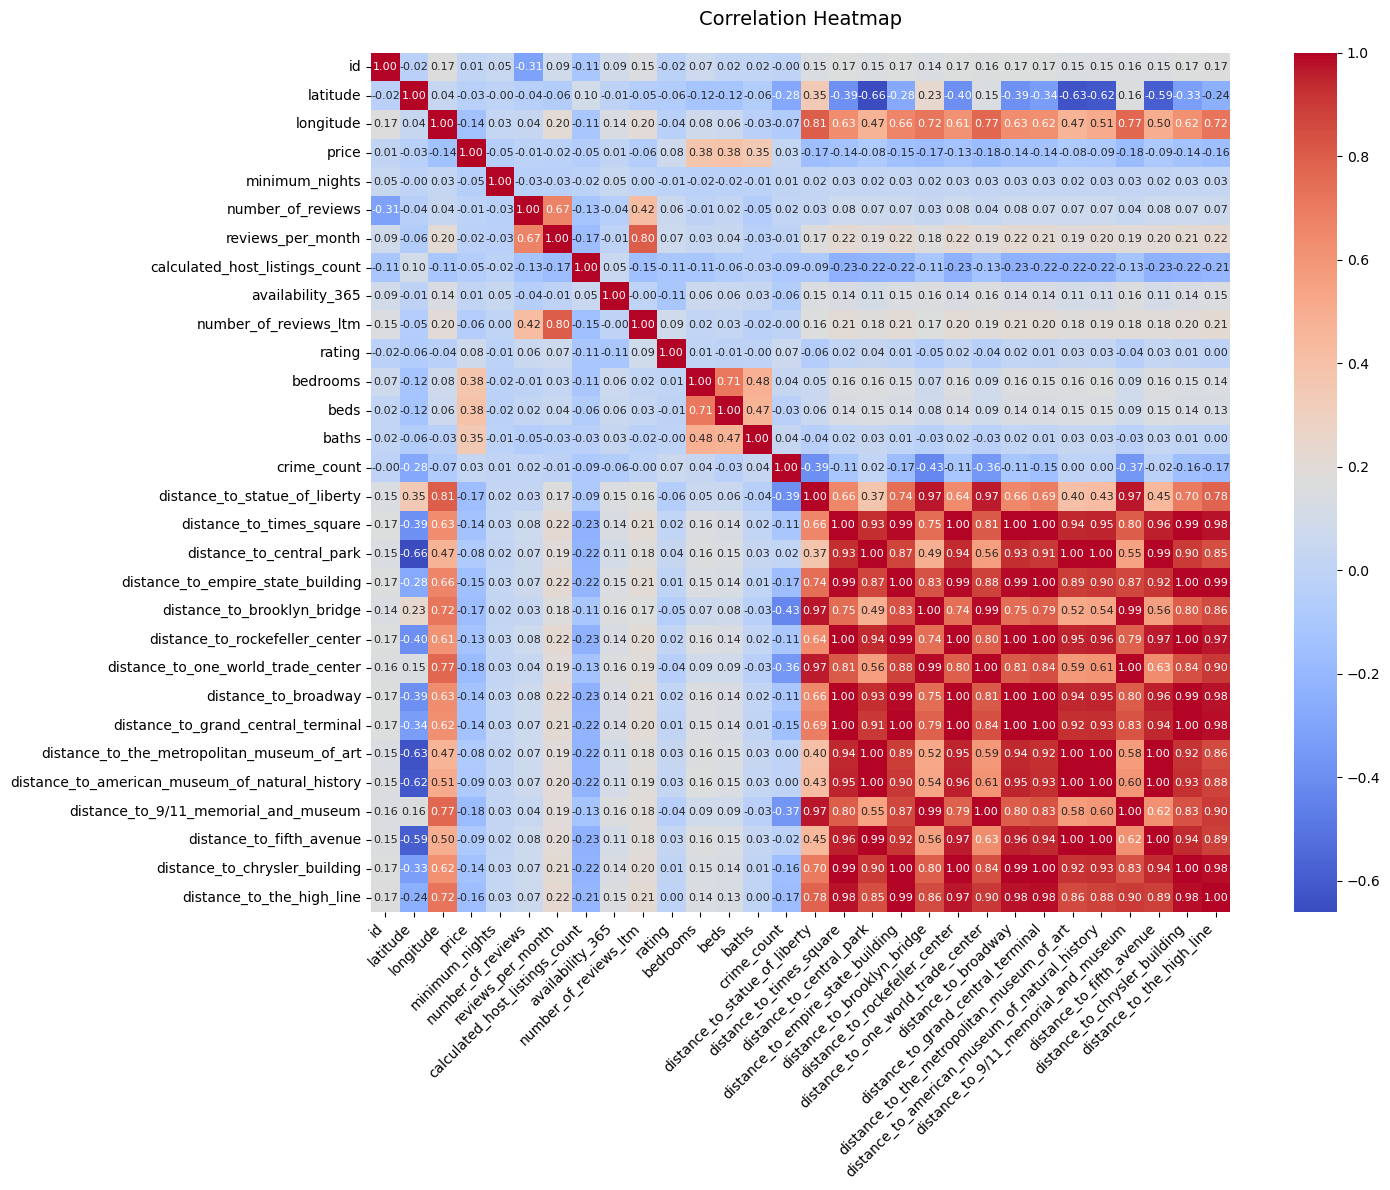

In [20]:
#Correlation Heatmap to visualize relationships between numeric features to select features for ML model

# Select numeric columns
numeric_cols = airbnb_crime.select_dtypes(include=[np.number])

# Compute correlations
corr = numeric_cols.corr()

# Set up figure size
plt.figure(figsize=(16, 12))

# Plot heatmap
sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f",       # show 2 decimal places
    cmap="coolwarm", # color palette
    cbar=True, 
    square=True, 
    annot_kws={"size": 8}  # smaller font for annotations
)

# Rotate axis labels for clarity
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.title("Correlation Heatmap", fontsize=14, pad=20)
plt.tight_layout()
plt.show()


OBS: Features we will keep: latitude, longitude, minimum_nights, number_of_reviews, availability_365, crime_count, calculated_host_listings_count, 
distance_to_statue_of_liberty, distance_to_times_square.

In [21]:
X = airbnb_crime[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'availability_365', 'crime_count',
               'calculated_host_listings_count', 'distance_to_statue_of_liberty', 'distance_to_times_square', 'neighbourhood_group', 'room_type','baths', 'bedrooms', 'rating']]
y = airbnb_crime['price']

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [23]:
from sklearn.preprocessing import MinMaxScaler

# Select only numeric columns
numeric_features = ['latitude', 'longitude', 'minimum_nights', 
                    'number_of_reviews', 'availability_365', 'crime_count',
                    'calculated_host_listings_count', 
                    'distance_to_statue_of_liberty', 'distance_to_times_square','baths', 'bedrooms', 'rating']

scaler = MinMaxScaler()
scaler.fit(X_train[numeric_features])

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Replace numeric columns with scaled versions
X_train_scaled[numeric_features] = scaler.transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])


In [24]:
# Put transformed data into a DataFrame (only numeric features)
X_train_transformed = pd.DataFrame(scaler.transform(X_train[numeric_features]), columns=numeric_features, index=X_train.index)
X_test_transformed = pd.DataFrame(scaler.transform(X_test[numeric_features]), columns=numeric_features, index=X_test.index)

In [25]:
# neighbourhood_group - nominal -> One Hot Encoding
airbnb_crime.neighbourhood_group.value_counts(dropna=False)

neighbourhood_group
Brooklyn         2079
Manhattan        1675
Queens           1190
Bronx             354
Staten Island      74
Name: count, dtype: int64

In [26]:
from sklearn.preprocessing import OneHotEncoder

oh_encoder = OneHotEncoder(drop='first')
oh_encoder.fit(airbnb_crime.loc[X_train.index, ['neighbourhood_group']])

X_train_encoded = pd.DataFrame.sparse.from_spmatrix(
    oh_encoder.transform(airbnb_crime.loc[X_train.index, ['neighbourhood_group']]),
    columns=oh_encoder.get_feature_names_out(),
    index=X_train.index
)
X_test_encoded = pd.DataFrame.sparse.from_spmatrix(
    oh_encoder.transform(airbnb_crime.loc[X_test.index, ['neighbourhood_group']]),
    columns=oh_encoder.get_feature_names_out(),
    index=X_test.index
)

X_train_encoded = pd.concat([X_train_encoded, X_train_transformed], axis=1)
X_test_encoded = pd.concat([X_test_encoded, X_test_transformed], axis=1)

In [27]:
X_train_encoded.isnull().sum()

C:\Users\anais\AppData\Local\Temp\ipykernel_20808\2341718705.py:1: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  X_train_encoded.isnull().sum()


neighbourhood_group_Brooklyn         False
neighbourhood_group_Manhattan        False
neighbourhood_group_Queens           False
neighbourhood_group_Staten Island    False
latitude                                 0
longitude                                0
minimum_nights                           0
number_of_reviews                        0
availability_365                         0
crime_count                              0
calculated_host_listings_count           0
distance_to_statue_of_liberty            0
distance_to_times_square                 0
baths                                    0
bedrooms                                 0
rating                                   0
dtype: Sparse[int64, False]

In [28]:
X_test_encoded.isnull().sum()

C:\Users\anais\AppData\Local\Temp\ipykernel_20808\138548256.py:1: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  X_test_encoded.isnull().sum()


neighbourhood_group_Brooklyn         False
neighbourhood_group_Manhattan        False
neighbourhood_group_Queens           False
neighbourhood_group_Staten Island    False
latitude                                 0
longitude                                0
minimum_nights                           0
number_of_reviews                        0
availability_365                         0
crime_count                              0
calculated_host_listings_count           0
distance_to_statue_of_liberty            0
distance_to_times_square                 0
baths                                    0
bedrooms                                 0
rating                                   0
dtype: Sparse[int64, False]

In [29]:
print(airbnb_crime["room_type"].isna().sum())
print(airbnb_crime["room_type"].unique())

0
['Entire home/apt' 'Private room' 'Shared room' 'Hotel room']


In [30]:
# room_type- ordinal -> Label Encoding
airbnb_crime.room_type.value_counts(dropna=False)

room_type
Entire home/apt    3082
Private room       2188
Shared room          80
Hotel room           22
Name: count, dtype: int64

In [31]:
# Define the mapping
room_type_map = {
    'Entire home/apt': 4,
    'Hotel room': 3,
    'Private room': 2,
    'Shared room': 1
}

# Apply the mapping to training and test sets
X_train_label = X_train[['room_type']].replace(room_type_map)
X_test_label = X_test[['room_type']].replace(room_type_map)

# Combine with your other encoded features

X_train_t = pd.concat(
    [X_train_encoded.reset_index(drop=True),
     X_train_label.reset_index(drop=True)],
    axis=1
)

X_test_t = pd.concat(
    [X_test_encoded.reset_index(drop=True),
     X_test_label.reset_index(drop=True)],
    axis=1
)



C:\Users\anais\AppData\Local\Temp\ipykernel_20808\3696907422.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train_label = X_train[['room_type']].replace(room_type_map)
C:\Users\anais\AppData\Local\Temp\ipykernel_20808\3696907422.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test_label = X_test[['room_type']].replace(room_type_map)


In [32]:
X_train_t['room_type'].value_counts()  # Check the count for unique values in room_type after encoding

room_type
4    2493
2    1730
1      58
3      16
Name: count, dtype: int64

In [33]:
X_train_t.isnull().sum()  # Check for any null values in the transformed training set

C:\Users\anais\AppData\Local\Temp\ipykernel_20808\993204000.py:1: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  X_train_t.isnull().sum()  # Check for any null values in the transformed training set


neighbourhood_group_Brooklyn         False
neighbourhood_group_Manhattan        False
neighbourhood_group_Queens           False
neighbourhood_group_Staten Island    False
latitude                                 0
longitude                                0
minimum_nights                           0
number_of_reviews                        0
availability_365                         0
crime_count                              0
calculated_host_listings_count           0
distance_to_statue_of_liberty            0
distance_to_times_square                 0
baths                                    0
bedrooms                                 0
rating                                   0
room_type                                0
dtype: Sparse[int64, False]

In [34]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=160) # n_neighbours is a "hyperparameter", which can be changed to improve performance of the model
knn.fit(X_train_t, y_train)

c:\Users\anais\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


KNeighborsRegressor(n_neighbors=160)

In [35]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_t, y_train)

c:\Users\anais\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


LinearRegression()

In [36]:
# Score the model
knn.score(X_test_t, y_test)

c:\Users\anais\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.07818193100789816

In [37]:
lr.score(X_test_t, y_test)

c:\Users\anais\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


0.12319602831152399

In [38]:
#==============================================================================5th Linear Regression Model============================================================

In [39]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(fit_intercept=True)

In [40]:
lin_reg.fit(X_train_t, y_train)

c:\Users\anais\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


LinearRegression()

In [41]:
print(lin_reg.score(X_train_t, y_train)) 
print(lin_reg.score(X_test_t, y_test)) 

0.37311992956259055
0.12319602831152399


c:\Users\anais\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
c:\Users\anais\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [42]:
lin_reg.feature_names_in_

array(['neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan',
       'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island',
       'latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'availability_365', 'crime_count',
       'calculated_host_listings_count', 'distance_to_statue_of_liberty',
       'distance_to_times_square', 'baths', 'bedrooms', 'rating',
       'room_type'], dtype=object)

In [43]:
lin_reg.coef_

array([ 2.74258167e+14, -1.58984993e+13, -8.99224917e+13, -9.35766115e+14,
       -5.10269189e+01,  8.41001342e+01, -2.86558671e+02, -1.30853890e+01,
        1.96445823e+01, -1.21002428e+15, -1.33922314e+02, -1.93591990e+02,
       -1.88182278e+01,  1.31788505e+03,  7.75734234e+02,  1.33223224e+02,
        3.12479906e+01])

In [44]:
import plotly.express as px
px.histogram(x=lin_reg.coef_, y=lin_reg.feature_names_in_)

In [45]:
#============================================================ 6th Decision Tree Model ============================================================

In [46]:
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor(
    max_depth=10, # 30, 50, 100 - we can have many more splits when we have continuous variables
    min_samples_split=2,
    max_leaf_nodes=30 # basically equivalent to max_depth but still considered
)

In [47]:
dt_reg.fit(X_train_t, y_train)

c:\Users\anais\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



DecisionTreeRegressor(max_depth=10, max_leaf_nodes=30)

In [48]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_pred = dt_reg.predict(X_test_t)

print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MSE: 70497.43481824185
RMSE: 265.5135303863851
MAE: 81.7099476885607
R²: 0.1134105693869566


c:\Users\anais\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

c:\Users\anais\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [49]:
#============================================================================== 7th Random Forest Model ============================================================

In [50]:
from sklearn.ensemble import RandomForestRegressor

rf_boot = RandomForestRegressor(n_estimators=50, max_depth=10, bootstrap=True)
rf_pasting = RandomForestRegressor(n_estimators=100, max_depth=10, bootstrap=False)

In [51]:
rf_boot.fit(X_train_t, y_train)
rf_pasting.fit(X_train_t, y_train)

c:\Users\anais\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

c:\Users\anais\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



RandomForestRegressor(bootstrap=False, max_depth=10)

In [52]:
print(rf_boot.score(X_train_t, y_train))
print(rf_pasting.score(X_train_t, y_train))

0.847223813982797
0.8731631044959617


c:\Users\anais\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

c:\Users\anais\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



In [53]:
print(rf_boot.score(X_test_t, y_test))
print(rf_pasting.score(X_test_t, y_test))

0.18509740153112675
0.0960683514413252


c:\Users\anais\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

c:\Users\anais\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



In [54]:
y_pred = rf_boot.predict(X_test_t)

print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MSE: 64797.234024154546
RMSE: 254.5530082795223
MAE: 71.3282842402797
R²: 0.18509740153112675


c:\Users\anais\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.

c:\Users\anais\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [55]:
y_pred = rf_pasting.predict(X_test_t)

print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


c:\Users\anais\anaconda3\Lib\site-packages\sklearn\utils\validation.py:877: UserWarning:

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.



MSE: 71876.40668166743
RMSE: 268.09775583109126
MAE: 79.25366168813387
R²: 0.0960683514413252


c:\Users\anais\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [57]:
pip install xgboost


   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ----- ---------------------------------- 8.4/56.8 MB 58.0 MB/s eta 0:00:01
   ------------- -------------------------- 18.9/56.8 MB 51.8 MB/s eta 0:00:01
   --------------------- ------------------ 30.9/56.8 MB 54.6 MB/s eta 0:00:01
   ------------------------------ --------- 43.8/56.8 MB 55.7 MB/s eta 0:00:01
   ---------------------------------------  56.6/56.8 MB 57.3 MB/s eta 0:00:01
   ---------------------------------------- 56.8/56.8 MB 51.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import numpy as np

# Drop columns not useful for prediction (IDs, text)
X = airbnb_crime.drop(columns=['id','price','last_review'])  # keep features
y = airbnb_crime['price']  # target variable

# Handle missing values (replace NaN with median)
X = X.fillna(X.median(numeric_only=True))

# Convert categorical variables to dummies (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [59]:
# Define model
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train model
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [60]:
# Predictions
y_pred = model.predict(X_test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")


RMSE: 257.92
R² Score: 0.249


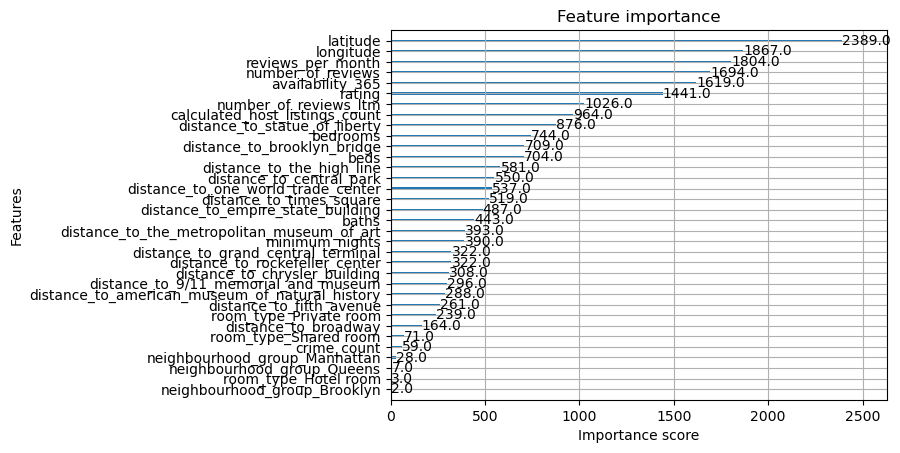

In [61]:
import matplotlib.pyplot as plt

xgb.plot_importance(model, importance_type='weight')
plt.show()


In [64]:
import numpy as np

# Transform price with log1p (handles zeros safely)
y_log = np.log1p(airbnb_crime['price'])


In [65]:
from sklearn.model_selection import train_test_split

X = airbnb_crime.drop(columns=['id','price','last_review'])
X = X.fillna(X.median(numeric_only=True))
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)


In [66]:
import xgboost as xgb

model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [67]:
y_pred_log = model.predict(X_test)

# Convert predictions back to original scale
y_pred = np.expm1(y_pred_log)

# If you want to evaluate
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred))
r2 = r2_score(np.expm1(y_test), y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")


RMSE: 262.25
R² Score: 0.223


In [74]:
import numpy as np

# Function to compute Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R * c

# Add distance to Manhattan center
city_center = (40.7580, -73.9855)
airbnb_crime['dist_to_center'] = airbnb_crime.apply(
    lambda row: haversine(row['latitude'], row['longitude'], city_center[0], city_center[1]),
    axis=1
)


In [75]:
airbnb_crime['price_log'] = np.log1p(airbnb_crime['price'])


In [70]:
import pandas as pd

X = airbnb_crime.drop(columns=['id','price','price_log','last_review'])
y = airbnb_crime['price_log']

# Handle missing values
X = X.fillna(X.median(numeric_only=True))

# Convert categorical variables to one-hot
X = pd.get_dummies(X, drop_first=True)


In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [77]:
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)


ValueError: feature_names mismatch: ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'rating', 'bedrooms', 'beds', 'baths', 'crime_count', 'distance_to_statue_of_liberty', 'distance_to_times_square', 'distance_to_central_park', 'distance_to_empire_state_building', 'distance_to_brooklyn_bridge', 'distance_to_rockefeller_center', 'distance_to_one_world_trade_center', 'distance_to_broadway', 'distance_to_grand_central_terminal', 'distance_to_the_metropolitan_museum_of_art', 'distance_to_american_museum_of_natural_history', 'distance_to_9/11_memorial_and_museum', 'distance_to_fifth_avenue', 'distance_to_chrysler_building', 'distance_to_the_high_line', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room'] ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'rating', 'bedrooms', 'beds', 'baths', 'crime_count', 'distance_to_statue_of_liberty', 'distance_to_times_square', 'distance_to_central_park', 'distance_to_empire_state_building', 'distance_to_brooklyn_bridge', 'distance_to_rockefeller_center', 'distance_to_one_world_trade_center', 'distance_to_broadway', 'distance_to_grand_central_terminal', 'distance_to_the_metropolitan_museum_of_art', 'distance_to_american_museum_of_natural_history', 'distance_to_9/11_memorial_and_museum', 'distance_to_fifth_avenue', 'distance_to_chrysler_building', 'distance_to_the_high_line', 'dist_to_center', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room']
training data did not have the following fields: dist_to_center

In [78]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
r2 = r2_score(y_test_orig, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")


NameError: name 'y_test_orig' is not defined